<a href="https://colab.research.google.com/github/Priyanka-code-sys/Thesis_Priyanka/blob/main/cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [ ]:
#set the memory growth in the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
#define strategy to use multiple gpus
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2021-12-14 00:48:14.571516: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 00:48:15.248849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4037 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
2021-12-14 00:48:15.249332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4529 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:03:00.0, compute capability: 7.5


In [ ]:
#load the dataset
df = pd.read_pickle('./dataset.pkl')

In [ ]:
df.head(10)

,review,star_rating
543115,check the running order great series both i...,0.8
648,five stars easy to set up,1.0
37116,imposes ton style sacha baron cohen est encor...,1.0
161750,one star one because there is no nill,0.2
508486,demi moore a delectable actress i enjoyed thi...,1.0
110113,cette série a très bien vieilli je n ai pas vu...,0.8
108052,parfait en effet que reprocher a ce disque qui...,1.0
228548,le cd de la honte je me passerai de commentai...,0.2
4254,bon app elle fait son boulot elle propose des...,0.8
92734,très beau film mais sans doute très bien avec...,0.2


In [ ]:
#split the sentences
df['clean_text'] = df['review'].map(lambda x:str(x).split())

In [ ]:
df.head(5)

,review,star_rating,clean_text
543115,check the running order great series both i...,0.8,"[check, the, running, order, great, series, bo..."
648,five stars easy to set up,1.0,"[five, stars, easy, to, set, up]"
37116,imposes ton style sacha baron cohen est encor...,1.0,"[imposes, ton, style, sacha, baron, cohen, est..."
161750,one star one because there is no nill,0.2,"[one, star, one, because, there, is, no, nill]"
508486,demi moore a delectable actress i enjoyed thi...,1.0,"[demi, moore, a, delectable, actress, i, enjoy..."


In [ ]:
#load the datasets
f = open("features.pkl",'rb')
X = pickle.load(f)
f = open("labels.pkl",'rb')
Y = pickle.load(f)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=512, split=' ')
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
X = pad_sequences(X)

In [ ]:
#check the features and vectors
print(X[:2])
print(Y[:2])

[[  0   0   0 ... 246   3 302]
 [  0   0   0 ...   8 387 117]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
#train test split
X_train = X[:80000]
Y_train = Y[:80000]

X_test = X[80000:]
Y_test = Y[80000:]

In [ ]:
from keras.layers import Input, Concatenate, Dense, Embedding, LSTM,SpatialDropout1D,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential

In [ ]:
#define convolution based model
with strategy.scope():
    model = Sequential()
    model.add(Embedding(50000, 128, input_length= X.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))),
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3736, 128)         6400000   
                                                                 
 conv1d (Conv1D)             (None, 3734, 32)          12320     
                                                                 
 conv1d_1 (Conv1D)           (None, 3732, 64)          6208      
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                        

In [ ]:
pred = model.predict(X_train[:3])
print(pred)

2021-12-14 00:48:25.833691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1351"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You 

Instructions for updating:
use `experimental_local_results` instead.


2021-12-14 00:48:27.199691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2021-12-14 00:48:27.631099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


[[0.19938664 0.2000388  0.19961394 0.19874787 0.20221274]
 [0.19982575 0.20035954 0.1996927  0.19810897 0.20201302]
 [0.19925861 0.19989438 0.19989415 0.19913653 0.20181637]]


In [ ]:
#fit the model on the dataset
history = model.fit(X_train,Y_train,epochs=3,batch_size=8,validation_split=0.2)

2021-12-14 00:48:29.165969: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3479"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:30"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 8
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You 

Epoch 1/3
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:b

2021-12-14 01:48:38.478903: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_52131"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:55"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 8
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You

8000/8000 [==============================] - 3968s 495ms/step - loss: 1.3360 - accuracy: 0.3940 - val_loss: 1.2546 - val_accuracy: 0.4637
Epoch 2/3
8000/8000 [==============================] - 3962s 495ms/step - loss: 1.1886 - accuracy: 0.4826 - val_loss: 1.1721 - val_accuracy: 0.4907
Epoch 3/3
8000/8000 [==============================] - 3965s 496ms/step - loss: 1.1472 - accuracy: 0.5029 - val_loss: 1.1492 - val_accuracy: 0.4976


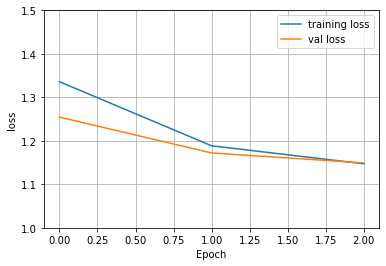

In [ ]:
#plot the history
import matplotlib.pyplot as plt
def plot_loss():
  plt.plot([1.3360,1.1886,1.1472], label='training loss')
  plt.plot([1.2546,1.1721,1.1492], label='val loss')
  plt.ylim([1.0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)
plot_loss()#plot the history

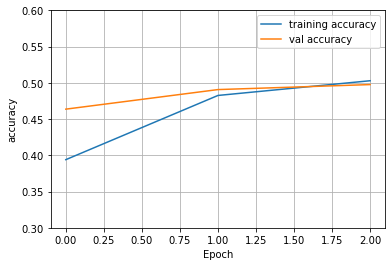

In [ ]:
def plot_accuracy():
  plt.plot([0.3940,0.4826,0.5029], label='training accuracy')
  plt.plot([0.4637,0.4907,0.4976], label='val accuracy')
  plt.ylim([0.3, 0.6])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

plot_accuracy()

In [ ]:
#save the model
model.save('./cnn_bilstm_model')

2021-12-14 04:06:46.381068: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./cnn_bilstm_model/assets


INFO:tensorflow:Assets written to: ./cnn_bilstm_model/assets


In [ ]:
#evaluate the model
model.evaluate(X_test,Y_test)

2021-12-14 04:06:50.912207: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_181490"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:96"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

625/625 [==============================] - 125s 197ms/step - loss: 1.1516 - accuracy: 0.5039


[1.1516118049621582, 0.5039499998092651]

In [ ]:
Y_preds = model.predict(X_test)
print(Y_preds.shape)

2021-12-14 04:22:08.708849: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_186877"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:120"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

(20000, 5)


In [ ]:
Y_preds_single = np.argmax(Y_preds,axis=1)
Y_real = np.argmax(Y_test,axis=1)

In [ ]:
#calculate the precision,recall,f1 score,confusion matrix for the model
from sklearn.metrics import f1_score,recall_score,precision_score,ConfusionMatrixDisplay

In [ ]:
#plot the f1 score the model across different classes
f1 = f1_score(Y_real,Y_preds_single,average=None)
recall = recall_score(Y_real,Y_preds_single,average=None)
precision = precision_score(Y_real,Y_preds_single,average=None)

In [ ]:
print("Weighted F1 Score : ",f1_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Recall Score : ",recall_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Precision Score : ",precision_score(Y_real,Y_preds_single,average="weighted"))

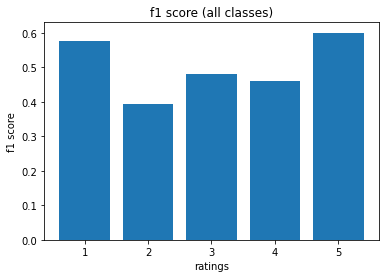

In [ ]:
#plot the f1 score
x = [1,2,3,4,5]
plt.bar(x,f1,label='f1 score')
plt.title('f1 score (all classes)')
plt.xlabel('ratings')
plt.ylabel('f1 score')
plt.show()

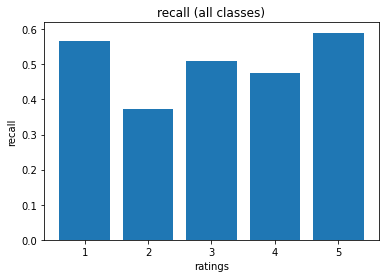

In [ ]:
#plot the recall
x = [1,2,3,4,5]
plt.bar(x,recall,label='recall')
plt.title('recall (all classes)')
plt.xlabel('ratings')
plt.ylabel('recall')
plt.show()

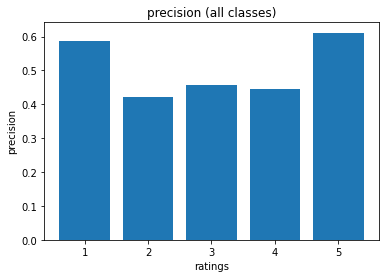

In [ ]:
#precision
x = [1,2,3,4,5]
plt.bar(x,precision,label='precision')
plt.title('precision (all classes)')
plt.xlabel('ratings')
plt.ylabel('precision')
plt.show()

In [ ]:
#output the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_real,Y_preds_single)
print(cm)

[[2353  963  369  232  227]
 [ 896 1460 1035  347  189]
 [ 318  631 2043  770  246]
 [ 180  272  806 1891  820]
 [ 267  139  217  997 2332]]


<AxesSubplot:>

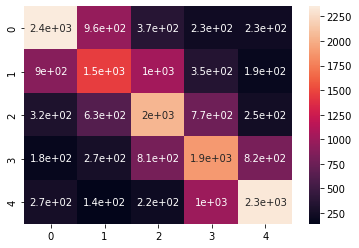

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='g')

In [ ]:
#function to test our own statements
import re

values = X_test[:3]
print(values)
preds = model.predict(values)
print("the number of stars in the process = ",np.argmax(preds,axis=1)+1)

[[  0   0   0 ...  75  75 141]
 [  0   0   0 ...  18  17   9]
 [  0   0   0 ...  70  10   1]]
the number of stars in the process =  [2 1 1]


2021-12-14 04:25:56.307632: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_191427"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:144"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 